### Imports απαιτούμενων πακέτων και βιβλιοθηκών

In [1]:
import cv2
import numpy as np
import scipy.io
import math
from math import pi
import operator
from numpy.linalg import inv
from numpy.linalg import det
import matplotlib.pyplot as plt
from scipy.ndimage import label
from scipy.ndimage import map_coordinates
import matplotlib.patches as patches
from matplotlib.pyplot import quiver
from scipy import signal
from scipy import ndimage
from scipy.ndimage import convolve1d
from itertools import chain
from scipy.stats import multivariate_normal

## Μέρος 1
### Παρακολούθηση Προσώπου και Χεριών με Χρήση του Πεδίου Οπτικής Ροής με τη μέθοδο Lucas-Kanade

###  1.1 Ανίχνευση Δέρματος Προσώπου και Χεριών (Ερώτημα Bonus)

In [2]:
mat = scipy.io.loadmat('skinSamplesRGB.mat')                         # Load mat file with skin samples
RGB_samples = mat.get("skinSamplesRGB")                              # RGB skin samples
YCrCb_samples = cv2.cvtColor(RGB_samples, cv2.COLOR_RGB2YCrCb)       # Covnert samples from RGB to YCbCr
Y = YCrCb_samples[:,:,0]                                             # Y channel
Cr = YCrCb_samples[:,:,1].flatten()                                  # Cr channel
Cb = YCrCb_samples[:,:,2].flatten()                                  # Cb channel
mean_Cr = np.mean(Cr)                                                # Cr mean value
mean_Cb = np.mean(Cb)                                                # Cb mean value
cov = np.cov(Cb,Cr)                                                  # Covariance matrix
mean = np.array([[mean_Cb,mean_Cr]])                                 # Vector with mean values

In [3]:
def disk_strel(n):
    '''
        Return a structural element, which is a disk of radius n.
    '''
    r = int(np.round(n))                         
    d = 2*r+1
    x = np.arange(d) - r
    y = np.arange(d) - r
    x, y = np.meshgrid(x,y)
    strel = x**2 + y**2 <= r**2
    return strel.astype(np.uint8)

In [4]:
def boundingBox(first_frame,mean,cov):
     
    image_YCrCb = cv2.cvtColor(first_frame, cv2.COLOR_BGR2YCrCb)    # Convert frame from BGR to YCrCb 
    
    P = np.zeros((image_YCrCb.shape[0],image_YCrCb.shape[1]))       # Initialize probability array
    
    covariance_det = np.linalg.det(cov)                             # Covariance determinant 
    covariance_inv = np.linalg.inv(cov)                             # Covariance inverse
    
    # Calculate probability array in every position (i,j)
    for i in range(image_YCrCb.shape[0]):
        for j in range(image_YCrCb.shape[1]):
            c = np.array([[image_YCrCb[i,j,2],image_YCrCb[i,j,1]]])
            P[i,j] = (1/(2*pi*np.sqrt(covariance_det))) * np.exp((-1/2)*(c-mean) @ covariance_inv @ ((c-mean).transpose())) 
            
    P = P / P.max()                                                 # Normalise probability array
    skin = (P > 0.06).astype(np.uint8)                               # Skin threshold 
    
    skin = cv2.morphologyEx(skin, cv2.MORPH_OPEN, disk_strel(1))    # Opening Filter
    
    skin = cv2.morphologyEx(skin, cv2.MORPH_CLOSE, disk_strel(10))  # Closing Filter

    regions,num_of_regions = scipy.ndimage.label(skin)              # Find different regions (face/hands)
    
    face = np.argwhere(regions==1)                                  # Find coordinates of the face
    left_hand = np.argwhere(regions==2)                             # Find coordinates of the left_hand
    right_hand = np.argwhere(regions==3)                            # Find coordinates of the right_hand

    face_up = face[:,0].min()                           # y coordinate of top-left corner of face bounding box
    face_down = face[:,0].max()                         # y coordinate of bottom-right corner of face bounding box
    face_left = face[:,1].min()                         # x coordinate of top-left corner of face bounding box
    face_right = face[:,1].max()                        # x coordinate of bottom-right corner face bounding box
    
    left_hand_up = left_hand[:,0].min()-6               # y coordinate of top-left corner of left_hand bounding box
    left_hand_down = left_hand[:,0].max()+6             # y coordinate of bottom-right corner of left_hand bounding box
    left_hand_left = left_hand[:,1].min()-6             # x coordinate of top-left corner of left_hand bounding box
    left_hand_right = left_hand[:,1].max()+6            # x coordinate of bottom-right corner left_hand bounding box
 
    right_hand_up = right_hand[:,0].min()-4             # y coordinate of top-left corner of right_hand bounding box
    right_hand_down = right_hand[:,0].max()+4           # y coordinate of bottom-right corner of right_hand bounding box
    right_hand_left = right_hand[:,1].min()-4           # x coordinate of top-left corner of right_hand bounding box
    right_hand_right = right_hand[:,1].max()+4          # x coordinate of bottom-right corner right_hand bounding box
    
        
    return [face_left, face_up, face_right-face_left, face_down-face_up],[left_hand_left, left_hand_up, left_hand_right-left_hand_left, left_hand_down-left_hand_up],[right_hand_left, right_hand_up, right_hand_right-right_hand_left, right_hand_down-right_hand_up]

### 1.2 Παρακολούθηση Προσώπου και Χεριών

### 1.2.1 Υλοποίηση του Αλγόριθμου των Lucas-Kanade

In [5]:
def lk(Iprev, Inext, rho, epsilon, d_x0, d_y0): 
    
    d_x = d_x0                                                            # Initialize displacement d_x
    d_y = d_y0                                                            # Initialize displacement d_y
      
    n = int(2*np.ceil(3*rho)+1)                                           # Gaussian kernel n
    gauss1D = cv2.getGaussianKernel(n, rho)                               # Column vector
    gauss2D = gauss1D @ gauss1D.T                                         # Symmetric gaussian kernel
    
    [Iprev_y,Iprev_x] = np.gradient(Iprev)                                # Gradients of Iprev
    x_0,y_0 = np.meshgrid(range(Iprev.shape[1]),range(Iprev.shape[0]))   
    
    for i in range(5):
        
        # Interpolated array 
        I_interpolated = map_coordinates(Iprev,[np.ravel(y_0+d_y), np.ravel(x_0+d_x)], order=1).reshape((Iprev.shape[0],Iprev.shape[1]))
        
        # A calculation
        A1 = map_coordinates(Iprev_x,[np.ravel(y_0+d_y), np.ravel(x_0+d_x)], order=1).reshape((Iprev.shape[0],Iprev.shape[1]))
        A2 = map_coordinates(Iprev_y,[np.ravel(y_0+d_y), np.ravel(x_0+d_x)], order=1).reshape((Iprev.shape[0],Iprev.shape[1]))
        
        # E calculation 
        E = Inext.astype(np.float) - I_interpolated.astype(np.float)
        
        # u calculation 
        b11 = cv2.filter2D(A1**2, -1, gauss2D) + epsilon
        b22 = cv2.filter2D(A2**2, -1, gauss2D) + epsilon
        b12 = cv2.filter2D(A1*A2, -1, gauss2D)
        c1 = cv2.filter2D(A1*E, -1, gauss2D)
        c2 = cv2.filter2D(A2*E, -1, gauss2D)
        detB = b11*b22 - b12**2
        u_x = (b22*c1 - b12*c2)/detB
        u_y = (b11*c2 - b12*c1)/detB
        
        # update optical flow 
        d_x = d_x + u_x
        d_y = d_y + u_y
        
    return d_x,d_y

In [6]:
def lk_math_convergence(Iprev, Inext, rho, epsilon, d_x0, d_y0): 
    
    d_x = d_x0                                                            # Initialize displacement d_x
    d_y = d_y0
    
    n = int(2*np.ceil(3*rho)+1)
    gauss1D = cv2.getGaussianKernel(n, rho)
    gauss2D = gauss1D @ gauss1D.T
    
    [Iprev_y,Iprev_x] = np.gradient(Iprev)
    x_0,y_0 = np.meshgrid(range(Iprev.shape[1]),range(Iprev.shape[0]))
    
    finish = 0
    k = 1
    counter = 1
    
    while(not(finish)):
        
        # Interpolated array
        I_interpolated = map_coordinates(Iprev,[np.ravel(y_0+d_y), np.ravel(x_0+d_x)], order=1).reshape((Iprev.shape[0],Iprev.shape[1]))
        
        # A calculation
        A1 = map_coordinates(Iprev_x,[np.ravel(y_0+d_y), np.ravel(x_0+d_x)], order=1).reshape((Iprev.shape[0],Iprev.shape[1]))
        A2 = map_coordinates(Iprev_y,[np.ravel(y_0+d_y), np.ravel(x_0+d_x)], order=1).reshape((Iprev.shape[0],Iprev.shape[1]))
        
        # E calculation 
        E = Inext.astype(np.float) - I_interpolated.astype(np.float)
        
        # u calculation
        b11 = cv2.filter2D(A1**2, -1, gauss2D) + epsilon
        b22 = cv2.filter2D(A2**2, -1, gauss2D) + epsilon
        b12 = cv2.filter2D(A1*A2, -1, gauss2D)
        c1 = cv2.filter2D(A1*E, -1, gauss2D)
        c2 = cv2.filter2D(A2*E, -1, gauss2D)
        detB = b11*b22 - b12**2
        u_x = (b22*c1 - b12*c2)/detB
        u_y = (b11*c2 - b12*c1)/detB
        u = np.vstack((u_x,u_y))
        d_x = d_x + u_x
        d_y = d_y + u_y
        criterion = LA.norm(u,2)
        if (criterion < 10**(-k)):
            finish = 1
        counter = counter + 1
    return d_x,d_y

### Απεικόνιση διανυσματικού πεδίου

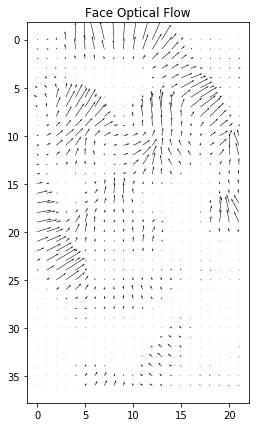

In [7]:
first_frame = cv2.imread('1.png',cv2.IMREAD_COLOR)
first_frame_gray = cv2.imread('1.png',cv2.IMREAD_GRAYSCALE)
first_frame_gray = first_frame_gray.astype(np.float) / first_frame_gray.max()

face,left_hand,right_hand = boundingBox(first_frame,mean,cov) 

cropped_first_frame = first_frame_gray[face[1]:(face[1]+face[3]),face[0]:(face[0]+face[2])]

second_frame = cv2.imread('2.png',cv2.IMREAD_COLOR)
second_frame_gray = cv2.imread('2.png',cv2.IMREAD_GRAYSCALE)
second_frame_gray = second_frame_gray.astype(np.float) / second_frame_gray.max()

cropped_second_frame = second_frame_gray[face[1]:(face[1]+face[3]),face[0]:(face[0]+face[2])]

d_x, d_y = lk(cropped_first_frame,cropped_second_frame, 3, 0.07, 0, 0)
d_x_r = cv2.resize(d_x, None, fx=0.3, fy=0.3)
d_y_r = cv2.resize(d_y, None, fx=0.3, fy=0.3)
f, axs = plt.subplots(figsize=(7,7))
axs.quiver(-d_x_r,-d_y_r,angles= 'xy')
axs.set_title("Face Optical Flow")
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')

### 1.2.2 Υπολογισμός της Μετατόπισης του Προσώπου και των Χεριών από το Πεδίο Οπτικής Ροής

In [8]:
def displ(d_x,d_y):
    energy = d_x**2 + d_y**2                              # Energy calculation
    max_energy = energy.max()                             # Max energy 
    has_strong_energy = (energy > 0.3*max_energy)         # Energy thresholding
    new_d_x = d_x[has_strong_energy==1]                   # Keep only d_x vectors with strong energy
    new_d_y = d_y[has_strong_energy==1]                   # Keep only d_y vectors with strong energy
    return np.mean(new_d_x),np.mean(new_d_y)              

### 1.2.3 Πολυ-Κλιμακωτός Υπολογισμός Οπτικής Ροής

In [9]:
def MultiScalelk(Iprev, Inext, rho, epsilon, d_x0, d_y0, scales):
    
    sigma = 3                                  
    n = int(2*np.ceil(3*sigma)+1)
    gauss1D = cv2.getGaussianKernel(n, sigma)  # Column vector
    gauss2D = gauss1D @ gauss1D.T              # Symmetric gaussian kernel
     
    pyramid_prev = {}                          # Initialise pyramid for previous frames
    pyramid_next = {}                          # Initialise pyramid for next frames 
    pyramid_prev[1] = Iprev                    # First level contains full size prev image
    pyramid_next[1] = Inext                    # First level contains full size next image
    
    
    # Compute each level of the pyramids
    for i in range(2,scales+1):
        
        Iprev_smoothed = cv2.filter2D(pyramid_prev[i-1], -1, gauss2D)                                # Image Smoothing
        Inext_smoothed = cv2.filter2D(pyramid_next[i-1], -1, gauss2D)                                # Image Smoothing
        pyramid_prev[i] = cv2.resize(Iprev_smoothed,(int(Iprev.shape[1]/2),int(Iprev.shape[0]/2)))   # Resize to half size
        pyramid_next[i] = cv2.resize(Inext_smoothed,(int(Inext.shape[1]/2),int(Inext.shape[0]/2)))   # Resize to half size
        
    d_x = d_x0
    d_y = d_y0
    
    # Calculate optical flow at each level moving from top  (higher level) to bottom (lower level)
    for i in range(scales,1,-1):
        d_x, d_y = lk(pyramid_prev[i], pyramid_next[i], rho, epsilon, d_x, d_y)                  # Apply Lucas-Kanade
        d_x = 2 * cv2.resize(d_x,((pyramid_prev[i-1].shape[1]),(pyramid_prev[i-1].shape[0])))    # Double the size
        d_y = 2 * cv2.resize(d_y,((pyramid_prev[i-1].shape[1]),(pyramid_prev[i-1].shape[0])))    # Double the size
    
    d_x, d_y = lk(pyramid_prev[1], pyramid_next[1], rho, epsilon, d_x, d_y)                       # Apply final LK

    return d_x, d_y

### Παρακολούθηση περιοχών ενδιαφέροντος

In [10]:
first_frame = cv2.imread('1.png',cv2.IMREAD_COLOR)
first_frame_gray = cv2.imread('1.png',cv2.IMREAD_GRAYSCALE)
first_frame_gray = first_frame_gray.astype(np.float) / first_frame_gray.max()

face,left_hand,right_hand = boundingBox(first_frame,mean,cov)

top_left_face_x = face[0]
top_left_face_y = face[1]
face_width = face[2]
face_height = face[3]
top_right_face_x = top_left_face_x + face_width
top_right_face_y = top_left_face_y + face_height


top_left_left_hand_x = left_hand[0]
top_left_left_hand_y = left_hand[1]
left_hand_width = left_hand[2]
left_hand_height = left_hand[3]
top_right_left_hand_x = top_left_left_hand_x + left_hand_width
top_right_left_hand_y = top_left_left_hand_y + left_hand_height


top_left_right_hand_x = right_hand[0]
top_left_right_hand_y = right_hand[1]
right_hand_width = right_hand[2]
right_hand_height = right_hand[3]
top_right_right_hand_x = top_left_right_hand_x + right_hand_width
top_right_right_hand_y = top_left_right_hand_y + right_hand_height

cropped_first_frame_face = first_frame_gray[top_left_face_y:top_right_face_y,top_left_face_x:top_right_face_x]
cropped_first_frame_left_hand = first_frame_gray[top_left_left_hand_y:top_right_left_hand_y,top_left_left_hand_x:top_right_left_hand_x]
cropped_first_frame_right_hand = first_frame_gray[top_left_right_hand_y:top_right_right_hand_y,top_left_right_hand_x:top_right_right_hand_x]


bounded_first_frame_face = cv2.rectangle(first_frame,(top_left_face_x,top_left_face_y),(top_right_face_x,top_right_face_y),(0,0,255),2) 
bounded_first_frame_left_hand = cv2.rectangle(bounded_first_frame_face,(top_left_left_hand_x,top_left_left_hand_y),(top_right_left_hand_x,top_right_left_hand_y),(0,255,0),2)
bounded_first_frame = cv2.rectangle(bounded_first_frame_left_hand,(top_left_right_hand_x,top_left_right_hand_y),(top_right_right_hand_x,top_right_right_hand_y),(255,0,0),2)

#cv2.imshow("Optical Flow",bounded_first_frame)
#cv2.waitKey(10)


prev_cropped_frame_face = cropped_first_frame_face
prev_cropped_frame_left_hand = cropped_first_frame_left_hand
prev_cropped_frame_right_hand = cropped_first_frame_right_hand

for i in range(65): 
    next_frame = cv2.imread('%s.png' %(i+2),cv2.IMREAD_COLOR)
    next_frame_gray = cv2.imread('%s.png' %(i+2),cv2.IMREAD_GRAYSCALE)
    next_frame_gray = next_frame_gray.astype(np.float) / next_frame_gray.max()

    next_cropped_frame_face = next_frame_gray[int(round(top_left_face_y)):int(round(top_right_face_y)),int(round(top_left_face_x)):int(round(top_right_face_x))]
    next_cropped_frame_left_hand = next_frame_gray[int(round(top_left_left_hand_y)):int(round(top_right_left_hand_y)),int(round(top_left_left_hand_x)):int(round(top_right_left_hand_x))]
    next_cropped_frame_right_hand = next_frame_gray[int(round(top_left_right_hand_y)):int(round(top_right_right_hand_y)),int(round(top_left_right_hand_x)):int(round(top_right_right_hand_x))]
    
    #d_x_face, d_y_face = lk(prev_cropped_frame_face,next_cropped_frame_face, 3, 0.07, 0, 0)
    d_x_face, d_y_face = MultiScalelk(prev_cropped_frame_face,next_cropped_frame_face, 3, 0.07, 0, 0, 4)
    #d_x_left_hand, d_y_left_hand = lk(prev_cropped_frame_left_hand,next_cropped_frame_left_hand, 3, 0.07, 0, 0)
    d_x_left_hand, d_y_left_hand = MultiScalelk(prev_cropped_frame_left_hand,next_cropped_frame_left_hand, 3, 0.07, 0, 0, 4)
    #d_x_right_hand, d_y_right_hand = lk(prev_cropped_frame_right_hand,next_cropped_frame_right_hand, 3, 0.07, 0, 0)
    d_x_right_hand, d_y_right_hand = MultiScalelk(prev_cropped_frame_right_hand,next_cropped_frame_right_hand, 3, 0.07, 0, 0, 4)
    
    displ_x_face,displ_y_face = displ(d_x_face,d_y_face)
    displ_x_left_hand,displ_y_left_hand = displ(d_x_left_hand,d_y_left_hand)
    displ_x_right_hand,displ_y_right_hand = displ(d_x_right_hand,d_y_right_hand)
    
    top_left_face_x = top_left_face_x - displ_x_face
    top_left_face_y = top_left_face_y - displ_y_face
    top_right_face_x = top_right_face_x - displ_x_face
    top_right_face_y = top_right_face_y - displ_y_face
    
    
    top_left_left_hand_x = top_left_left_hand_x - displ_x_left_hand
    top_left_left_hand_y = top_left_left_hand_y - displ_y_left_hand
    top_right_left_hand_x = top_right_left_hand_x - displ_x_left_hand
    top_right_left_hand_y = top_right_left_hand_y - displ_y_left_hand
    
    top_left_right_hand_x = top_left_right_hand_x - displ_x_right_hand
    top_left_right_hand_y = top_left_right_hand_y - displ_y_right_hand
    top_right_right_hand_x = top_right_right_hand_x - displ_x_right_hand
    top_right_right_hand_y = top_right_right_hand_y - displ_y_right_hand
    
    bounded_next_frame_face = cv2.rectangle(next_frame,(int(round(top_left_face_x)),int(round(top_left_face_y))),(int(round(top_right_face_x)),int(round(top_right_face_y))),(0,0,255),2)
    bounded_next_frame_left_hand  = cv2.rectangle(bounded_next_frame_face,(int(round(top_left_left_hand_x)),int(round(top_left_left_hand_y))),(int(round(top_right_left_hand_x)),int(round(top_right_left_hand_y))),(0,255,0),2)
    bounded_next_frame = cv2.rectangle(bounded_next_frame_left_hand,(int(round(top_left_right_hand_x)),int(round(top_left_right_hand_y))),(int(round(top_right_right_hand_x)),int(round(top_right_right_hand_y))),(255,0,0),2)
    
    #cv2.imshow("Optical Flow",bounded_next_frame)
    #cv2.waitKey(50)
    
    prev_cropped_frame_face = next_frame_gray[int(round(top_left_face_y)):int(round(top_right_face_y)),int(round(top_left_face_x)):int(round(top_right_face_x))]
    prev_cropped_frame_left_hand = next_frame_gray[int(round(top_left_left_hand_y)):int(round(top_right_left_hand_y)),int(round(top_left_left_hand_x)):int(round(top_right_left_hand_x))]
    prev_cropped_frame_right_hand = next_frame_gray[int(round(top_left_right_hand_y)):int(round(top_right_right_hand_y)),int(round(top_left_right_hand_x)):int(round(top_right_right_hand_x))]

    
cv2.destroyAllWindows()

### Εναλλακτική Υλοποίηση

Παρακάτω παρατίθεται μια εναλλακτική υλοποίηση του tracking των περιoχών ενδιαφέροντος με εφαρμογή πρώτα του αλγορίθμου LK στα αρχικά frames και έπειτα περικοπή του διανυσματικού πεδίου στις περιοχές των bounding boxes (αντί για περικοπή εξ'αρχής των εικόνων του βίντεο και εφαρμογή LK στις περιοχές αυτές). Η εναλλακτική αυτή προσέγγιση έχει αυξημένη υπολογιστική πολυπλοκότητα λόγω της εφαρμογής του LK σε εικόνες μεγαλύτερου μεγέθους, ωστόσο φαίνεται να εξάγει πιο "σωστά" το διανυσματικό πεδίο αφού εφαρμόζεται πάνω σε όλη την εικόνα,η οποία στην συνέχεια περικόπτεται σύμφωνα με τις περιοχές ενδιαφέροντος.

In [11]:
first_frame = cv2.imread('1.png',cv2.IMREAD_COLOR)
first_frame_gray = cv2.imread('1.png',cv2.IMREAD_GRAYSCALE)
first_frame_gray = first_frame_gray.astype(np.float) / first_frame_gray.max()

face,left_hand,right_hand = boundingBox(first_frame,mean,cov)

top_left_face_x = face[0]
top_left_face_y = face[1]
face_width = face[2]
face_height = face[3]
top_right_face_x = top_left_face_x + face_width
top_right_face_y = top_left_face_y + face_height

top_left_left_hand_x = left_hand[0]
top_left_left_hand_y = left_hand[1]
left_hand_width = left_hand[2]
left_hand_height = left_hand[3]
top_right_left_hand_x = top_left_left_hand_x + left_hand_width
top_right_left_hand_y = top_left_left_hand_y + left_hand_height

top_left_right_hand_x = right_hand[0]
top_left_right_hand_y = right_hand[1]
right_hand_width = right_hand[2]
right_hand_height = right_hand[3]
top_right_right_hand_x = top_left_right_hand_x + right_hand_width
top_right_right_hand_y = top_left_right_hand_y + right_hand_height

prev_frame_gray = first_frame_gray.copy()

for i in range(65):
    
    next_frame = cv2.imread('%s.png' %(i+2),cv2.IMREAD_COLOR)
    next_frame_gray = cv2.imread('%s.png' %(i+2),cv2.IMREAD_GRAYSCALE)
    next_frame_gray = next_frame_gray.astype(np.float) / next_frame_gray.max()
    
    #d_x,d_y = MultiScalelk(prev_frame_gray,next_frame_gray, 3, 0.07, 0, 0, 4)
    d_x,d_y = lk(prev_frame_gray,next_frame_gray, 3, 0.07, 0, 0)

    d_x_face = d_x[int(round(top_left_face_y)):int(round(top_right_face_y)),int(round(top_left_face_x)):int(round(top_right_face_x))]
    d_y_face = d_y[int(round(top_left_face_y)):int(round(top_right_face_y)),int(round(top_left_face_x)):int(round(top_right_face_x))]
    d_x_left_hand = d_x[int(round(top_left_left_hand_y)):int(round(top_right_left_hand_y)),int(round(top_left_left_hand_x)):int(round(top_right_left_hand_x))]  
    d_y_left_hand = d_y[int(round(top_left_left_hand_y)):int(round(top_right_left_hand_y)),int(round(top_left_left_hand_x)):int(round(top_right_left_hand_x))]  
    d_x_right_hand = d_x[int(round(top_left_right_hand_y)):int(round(top_right_right_hand_y)),int(round(top_left_right_hand_x)):int(round(top_right_right_hand_x))] 
    d_y_right_hand = d_y[int(round(top_left_right_hand_y)):int(round(top_right_right_hand_y)),int(round(top_left_right_hand_x)):int(round(top_right_right_hand_x))]  
    
    displ_x_face,displ_y_face = displ(d_x_face,d_y_face)
    displ_x_left_hand,displ_y_left_hand = displ(d_x_left_hand,d_y_left_hand)
    displ_x_right_hand,displ_y_right_hand = displ(d_x_right_hand,d_y_right_hand)
    
    top_left_face_x = top_left_face_x - displ_x_face
    top_left_face_y = top_left_face_y - displ_y_face
    top_right_face_x = top_right_face_x - displ_x_face
    top_right_face_y = top_right_face_y - displ_y_face
    
    top_left_left_hand_x = top_left_left_hand_x - displ_x_left_hand
    top_left_left_hand_y = top_left_left_hand_y - displ_y_left_hand
    top_right_left_hand_x = top_right_left_hand_x - displ_x_left_hand
    top_right_left_hand_y = top_right_left_hand_y - displ_y_left_hand
    
    top_left_right_hand_x = top_left_right_hand_x - displ_x_right_hand
    top_left_right_hand_y = top_left_right_hand_y - displ_y_right_hand
    top_right_right_hand_x = top_right_right_hand_x - displ_x_right_hand
    top_right_right_hand_y = top_right_right_hand_y - displ_y_right_hand
    
    bounded_next_frame_face = cv2.rectangle(next_frame,(int(round(top_left_face_x)),int(round(top_left_face_y))),(int(round(top_right_face_x)),int(round(top_right_face_y))),(0,0,255),2)
    bounded_next_frame_left_hand  = cv2.rectangle(bounded_next_frame_face,(int(round(top_left_left_hand_x)),int(round(top_left_left_hand_y))),(int(round(top_right_left_hand_x)),int(round(top_right_left_hand_y))),(0,255,0),2)
    bounded_next_frame = cv2.rectangle(bounded_next_frame_left_hand,(int(round(top_left_right_hand_x)),int(round(top_left_right_hand_y))),(int(round(top_right_right_hand_x)),int(round(top_right_right_hand_y))),(255,0,0),2) 
    
    #cv2.imshow("Optical Flow",bounded_next_frame)
    #cv2.waitKey(5)
    
    prev_frame_gray = next_frame_gray.copy()
    
cv2.destroyAllWindows()